# Randomizing Load Curves

In [1]:
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import datetime
import scipy
import seaborn as sns

In [ ]:
df = pd.read_csv('../data/claes_test.csv', index_col=0, parse_dates=True)
df.drop(columns='V3', inplace=True)

In [ ]:
# A function to copy a load profile with stochastic deviation
# from the original. The values varies according to a gaussian 
# distribution, with default and mu = 0, sigma = 0.1. The
# funtion returns a copy of the dataframe with the new column. 

def copy_load_stochastic(dataframe, column_name, sigma=0.1):
    
    min_prob, max_prob = -sigma, sigma
    prob_array = (max_prob - min_prob) * np.random.random_sample(size=dataframe.shape[0]) + min_prob
    new_col_name = column_name + '_stoch_copy'
    dataframe[new_col_name] = dataframe[column_name] + dataframe[column_name].mul(prob_array)
    
    return dataframe

In [ ]:
df_with_copy = copy_load_stochastic(df, 'V4',sigma=0.5)

In [ ]:
df_with_copy.head()

In [ ]:
df_with_copy['Year'] = df_with_copy.index.year
df_with_copy['Month'] = df_with_copy.index.month
df_with_copy['Weekday Name'] = df_with_copy.index.weekday_name

In [ ]:
y1 = df_with_copy['V4'].resample('W').mean()
y2 = df_with_copy['V4_stoch_copy'].resample('W').mean()

fig, ax = plt.subplots()
ax.plot(y1.loc['2018-10':'2019-02'], label='V4')
ax.plot(y2.loc['2018-10':'2019-02'], marker='.', linestyle='-', linewidth=0.5, label='V4 copy')
ax.set_ylabel('Electricity Consumption')
ax.legend();

# Creating Electrical Substation

In [ ]:
def input_allocation_dict(load_type_list):
    allocation_dict = dict()
    for load in load_type_list:
        allocation_dict[load] = int(input('Number of '+ load + ': '))
    return allocation_dict
    

In [ ]:
# Returns an updated dataframe object with
# a new profile added according to the input parameters. 

def read_LP(dataframe,load_type, num):
    path = None #Finding the csv-path. Fix better solution later. .json?
    num_list = [i for i in range(0,num +1)]
    if load_type == 'house_new':         
        path = '../data/new_houses.csv'
    elif load_type == 'house_old':
        path = '../data/old_houses.csv'
    elif load_type == 'house_mix_DH':
        path = '../data/mixed_ages_houses_district_heating.csv'
    elif load_type == 'appart_DH':
        path = '../data/new_appartments_district_heating.csv'
    
    if path != None:
        LP_cols = pd.read_csv(path, index_col = 0, 
                              parse_dates = True, 
                              usecols = num_list) # Fix for out of range. Use stochastic copy?
        LP_cols.columns = [load_type + str(i) for i in np.arange(1,len(LP_cols.columns)+1)]
        
        if dataframe.empty:
            dataframe = LP_cols
        else:  #Inner join for date compatability. Needs fixing if changing index structure!!
            dataframe = dataframe.merge(LP_cols, how = 'inner', left_index=True, right_index=True)          
    
    return dataframe

In [ ]:
temp_data = pd.read_csv('../data/stockholm_mintemp.csv', index_col = 0, parse_dates = True)


In [ ]:
temp_data.dtypes

In [ ]:
region_path_dict = {'Stockholm': '../data/stockholm_mintemp.csv'}

In [ ]:
def find_coldest_days(data_path, num, start, end):
    temp_data = pd.read_csv(data_path, index_col = 0, parse_dates = True)
    
    temp_data = temp_data[start:end]
    
    
    return list_of_dates

In [ ]:
def introduce_flexibility(dataframe,
                          region,
                          days = 17, 
                          percent_loads = 0.5, 
                          reduction = 0.67):
    
    start_date, end_date = dataframe.index[0], dataframe.index[-1]
    
    days_to_reduce = find_coldest_days(region_path_dict[region], 
                                       num = days, 
                                       start = start_date, 
                                       end = end_date)
    
    

In [ ]:
def new_calculation(flexibiltiy = True, region = 'Stockholm'):
    
    substation = create_substation()
    
    if flexibility:
        substation = introduce_flexibility(substation, region)

In [ ]:
new_calculation()

# PV class

In [55]:
import pandas as pd

class PV:
    '''
    Class representing PVs.
    Parameters: 
        size: 
            an int: 69/400/868 and represents m2.
        start:
            
    '''
    # Nameing here? e.g. 400 vs medium etc.
    path_dict = {69 : '../data/PV/pv69prod.csv' ,
                 400 : '../data/PV/pv400prod.csv',
                 868 : '../data/PV/pv868prod.csv'}

    def __init__(self, size, start, end, ID):
        self.size = size
        self.ID = ID
        self.start = start
        self.end = end
        self.mu = None
        self.sigma = None
        self.dataframe = pd.DataFrame(index = pd.date_range(start = start,
                                                            end = end, 
                                                            freq = 'H'),
                                      columns = ['Production'])
        self.populate_dataframe()

    def populate_dataframe(self):
        # Load the PV data as is
        csv_path = self.path_dict[self.size]
        pv_data = pd.read_csv(csv_path)
        ind = pd.date_range(start = self.start, periods = pv_data.shape[0], freq = 'H')
        pv_data.index = ind
        
        # Number of years of interest
        num_years = self.dataframe.index.year.nunique()
        first_year = self.dataframe.index[0].year

        # Generalize the data to all years of interest
        for i in range(0,num_years):
            # Below is a costum merge since the built-in is stupid hehe
            self.dataframe.loc[self.dataframe.index.isin(pv_data.index), pv_data.columns] = pv_data.loc[pv_data.index.isin(self.dataframe.index),pv_data.columns].values
            pv_data.index = pv_data.index.map(lambda x: x + pd.DateOffset(years=1))
        
        # Set missing values to 0 and convert to kWh
        self.dataframe.fillna(0, inplace = True)
        self.dataframe['Production'] /= 1000
        
    
    def calculate_norm(self):
        mu, sigma = scipy.stats.norm.fit(self.dataframe['Production'].tolist())
        self.mu, self.sigma = round(mu,3), round(sigma,3)
        
    def plot(self):
        #%matplotlib notebook
        plt.plot(self.dataframe)
        plt.title('Production of a {} m2 PV plant.'.format(self.size))
        plt.ylabel('Production [kWh]')
        
    def description(self):
        self.calculate_norm()
        return ('A {} m2 PV plant.'.format(self.size)\
                + ' The average production is of the plant is {} (-/+ {}) kWh per hour.'.format(self.mu,self.sigma))
        
        
    def be_random(self, sigma = 0.1, inplace = True):
        '''
        Introducing randomness to the PV production data through a 
        stochastic deviation from the original. The values varies 
        according to a gaussian distribution, 
        with default and mu = 0, sigma = 0.1. 
        '''
        min_prob, max_prob = -sigma, sigma
        prob_array = (max_prob - min_prob) * np.random.random_sample(size=self.dataframe.shape[0]) + min_prob
        new_col_name = 'Production' + '_stoch_copy'
        if inplace:
            self.dataframe['Production'] += self.dataframe['Production'].mul(prob_array)
        else:
            self.dataframe[new_col_name] = self.dataframe['Production'] + self.dataframe['Production'].mul(prob_array)
            

In [56]:
pv = PV(size = 69, start='2017-01-01', end = '2017-12-31', ID = 2)

In [58]:
pv.be_random()
pv.description()

'A 69 m2 PV plant. The average production is of the plant is 1.305 (-/+ 2.222) kWh per hour.'

<IPython.core.display.Javascript object>


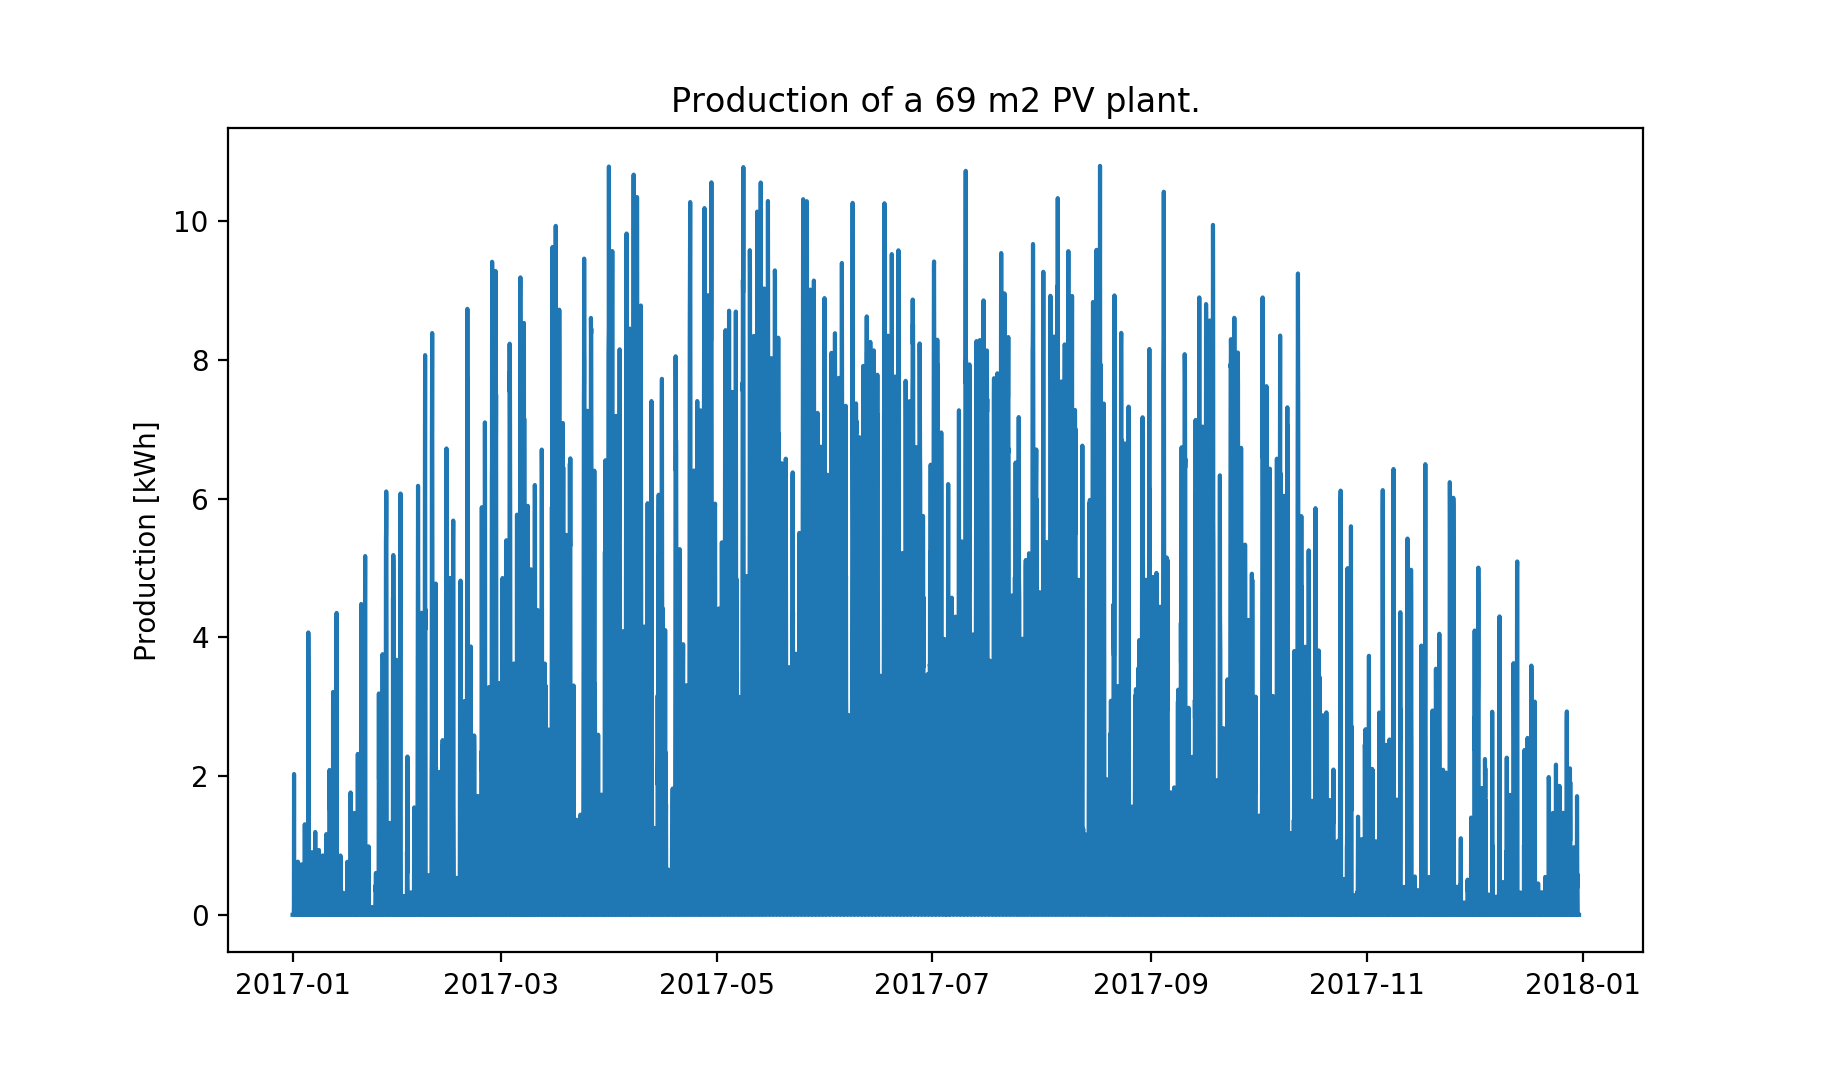

In [59]:
%matplotlib notebook
pv.plot()